In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts3'
aep = os.path.join(tp, '2022-08-10_16:48:21.436750_aeloss.dat')
tep = os.path.join(tp, '2022-08-10_16:48:21.436750_totallosses.dat')
eep = os.path.join(tp, '2022-08-10_16:48:21.436750_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 LiF 
 N 
 N2 


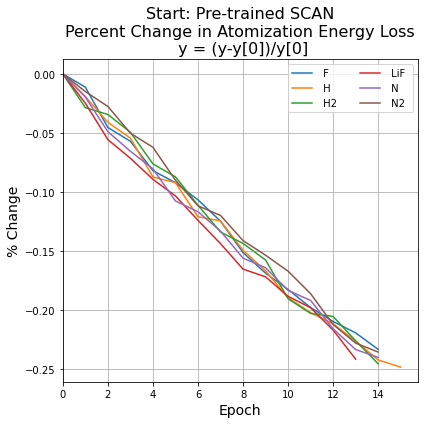

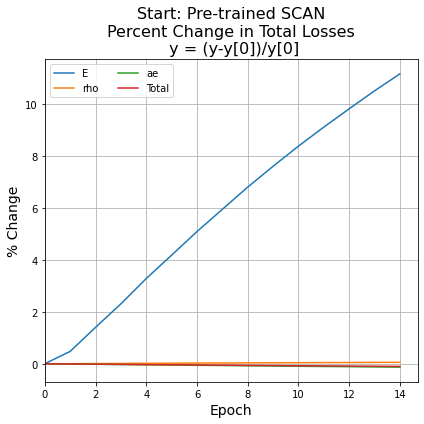

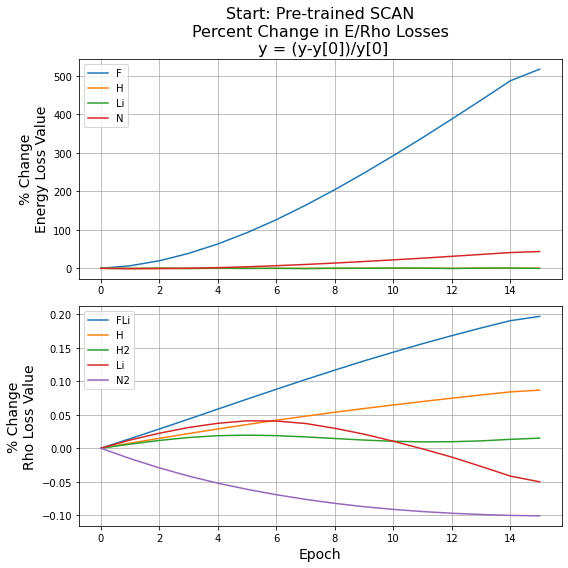

In [4]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts2ae.png'), dpi=800)

f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts2te.png'), dpi=800)

def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'pts2er.png'), dpi=800)

In [10]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/pts2'
aep = os.path.join(tp, '2022-08-05_17:01:57.494806_aeloss.dat')
tep = os.path.join(tp, '2022-08-05_17:01:57.494806_totallosses.dat')
eep = os.path.join(tp, '2022-08-05_17:01:57.494806_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 LiF 
 N 
 N2 


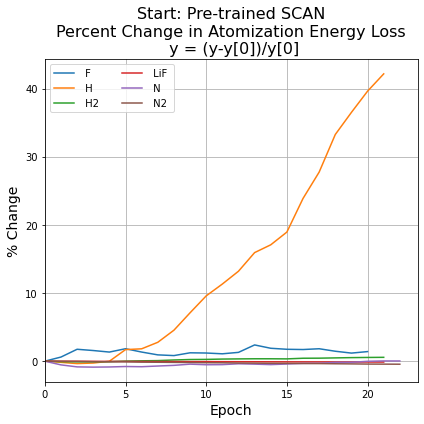

In [11]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'ptsae.png'), dpi=800)

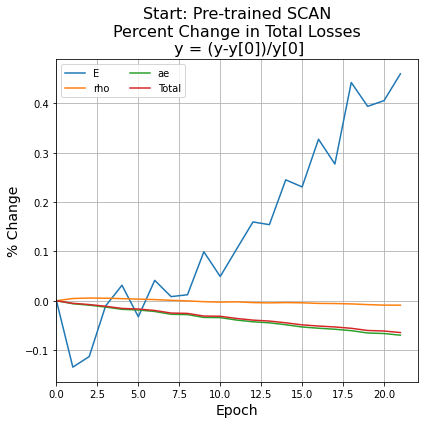

In [4]:
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: Pre-trained SCAN\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'ptste.png'), dpi=800)

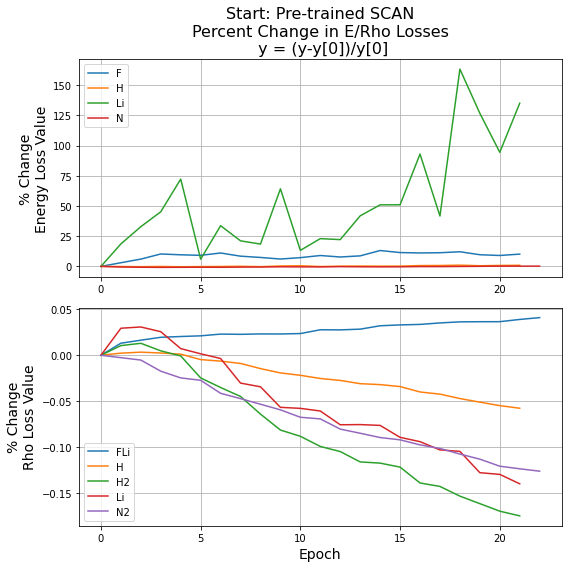

In [5]:
def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: Pre-trained SCAN\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'ptser.png'), dpi=800)

In [6]:
tp = '/home/awills/Documents/Research/swxcd/train/test_subset2/xcd'
aep = os.path.join(tp, '2022-08-06_13:30:34.553955_aeloss.dat')
tep = os.path.join(tp, '2022-08-06_13:30:34.553955_totallosses.dat')
eep = os.path.join(tp, '2022-08-06_13:30:34.553955_evalloss.dat')
ae = pd.read_csv(aep, delimiter='\t', skiprows=1, names = ['blank', 'Epoch', 'midx', 'form', 'sym', 'ae'])
te = pd.read_csv(tep, delimiter='\t', skiprows=1, names = ['Epoch', 'E', 'rho', 'ae', 'total'])
ee = pd.read_csv(eep, delimiter='\t', skiprows=0, names = ['Epoch', 'form', 'sym', 'k1', 'k1l', 'k2', 'k2l'])

 F 
 H 
 H2 
 LiF 
 N 
 N2 


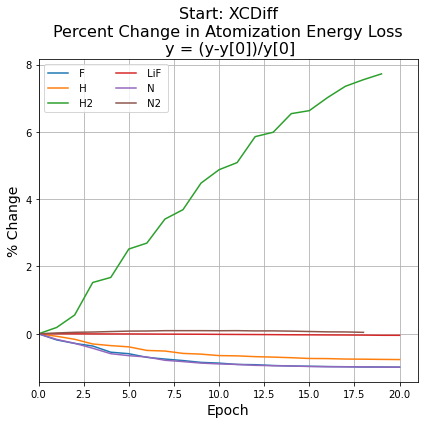

In [7]:
figp = '/home/awills/Documents/Research/figs/ml'
aeg = ae.groupby(['sym','Epoch']).mean()
df = aeg
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)
syms = np.unique(ae['sym'].values)
for s in syms:
    print(s)
    y = df.loc[s]['ae'].values
    y = (y - y[0])/y[0]
    ax.plot(y, label=s)

ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: XCDiff\nPercent Change in Atomization Energy Loss\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'xcdae.png'), dpi=800)

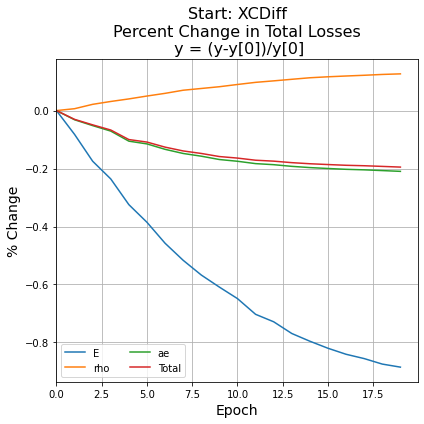

In [8]:
f = plt.figure(figsize=(6,6))
ax = f.add_subplot(111)

tel = te['E'].values
ter = te['rho'].values
tea = te['ae'].values
tet = te['total'].values

tel = (tel - tel[0])/tel[0]
ter = (ter - ter[0])/ter[0]
tea = (tea - tea[0])/tea[0]
tet = (tet - tet[0])/tet[0]

ax.plot(tel, label='E')
ax.plot(ter, label='rho')
ax.plot(tea, label='ae')
ax.plot(tet, label='Total')


ax.set_xlim(0,None)
#ax.set_ylim(-1, 1)
ax.legend(ncol=2)
ax.grid()

ax.set_title('Start: XCDiff\nPercent Change in Total Losses\n y = (y-y[0])/y[0]', fontsize=16)
ax.set_ylabel('% Change', fontsize=14)
ax.set_xlabel('Epoch', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figp, 'xcdte.png'), dpi=800)

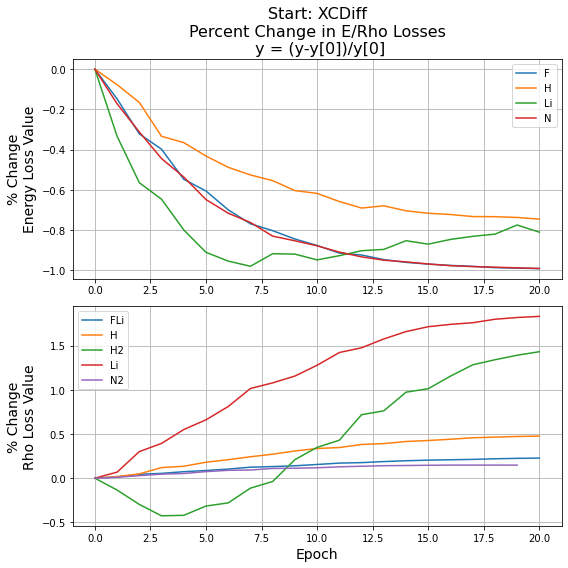

In [9]:
def get_col_key(form, odf, key):
    ks = odf[odf['form'] == form].iloc[0][['k1','k2']]
    if key == ks[0]:
        return 'k1l'
    elif key == ks[1]:
        return 'k2l'
    else:
        return None
eg = ee.groupby(['form', 'Epoch']).mean()
syms = np.unique(ee['form'].values)
f = plt.figure(figsize=(8, 8))
eax = f.add_subplot(211)
rax = f.add_subplot(212)
ks = ['E','rho']
for s in syms:
    ek = get_col_key(s, ee, key='E')
    rk = get_col_key(s, ee, key='rho')
    if ek:
        ey = eg.loc[s][ek].values
        ey = (ey-ey[0])/ey[0]
        eax.plot(ey, label=s)
    if rk:
        ry = eg.loc[s][rk].values
        ry = (ry-ry[0])/ry[0]
        rax.plot(ry, label=s)

eax.legend()
rax.legend()

eax.grid()
rax.grid()

eax.set_ylabel('% Change\nEnergy Loss Value', fontsize=14)
rax.set_ylabel('% Change\nRho Loss Value', fontsize=14)

rax.set_xlabel('Epoch', fontsize=14)

eax.set_title('Start: XCDiff\nPercent Change in E/Rho Losses\n y = (y-y[0])/y[0]', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(figp, 'xcder.png'), dpi=800)